In [1]:
import numpy as np
import pandas as pd
import spacy
import glob 
import pyLDAvis
import pyLDAvis.sklearn
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm import tqdm
import matplotlib.pyplot as plt
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from spacy.lang.nl.stop_words import STOP_WORDS
from string import punctuation
from heapq import nlargest
from spacy.lang.nl import Dutch

C:\Users\sebas\anaconda3\envs\nlp\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
def loadLangModel(lang):
    """
    This function loads a spacy model and return it.
    """
    return spacy.load(lang)

In [3]:
# load a medium sized dutch language model in spacy
nlp = loadLangModel('nl_core_news_md')

#### Functions for word frequencie, percentage importance, entities visualization, POS and summarization of text

In [4]:
stopwords = list(STOP_WORDS)

In [5]:
#Using spaCy's built-in visualizer to detect named entities in the document
def visualizeEntities(doc):
    """
    This function uses displacy from spaCy to show named entities of a document
    """
    displacy.render(doc, style="ent", jupyter=True)
    

In [6]:
#Calculating word frequencies from the text after removing stopwords and puntuactions:
def displayWordFrequencies(doc, stopwords):
    """
    this function returns word frequenties and should be given a doc and the stopwords corresponding to the imported language
    in spacy
    For example in Dutch:
    from spacy.lang.nl.stop_words import STOP_WORDS
    """
    #First lemmatize the doc
    doc = str(" ".join([i.lemma_ for i in doc]))
    doc = nlp(doc)
    word_frequencies={}
    for word in doc:
        if word.text.lower() not in stopwords:
            if word.text.lower() not in punctuation:
                if word.text not in word_frequencies.keys():
                    word_frequencies[word.text] = 1
                else:
                    word_frequencies[word.text] += 1
    return word_frequencies

In [7]:
#Calculate the maximum frequency and divide it by all frequencies to get normalized word frequencies.
def percentageImportance(word_frequencies):
    """
    This function returns the word importance percentage, we must pass word frequencie first 
    """
    max_frequency=max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word]=(word_frequencies[word]/max_frequency)
    
    
    return word_frequencies

In [18]:
#Ref for attempting summarization https://www.numpyninja.com/post/text-summarization-through-use-of-spacy-library
def createSummary(doc, word_frequencies):
    """
    this function creates a summary of the given text
    """
    #Get sentence tokens 
    sentence_tokens= [sent for sent in doc.sents]
    #Calculate the most important sentences by adding the word frequencies in each sentence.
    sentence_scores = {}
    for sent in sentence_tokens:
        for word in sent:
            if word.text.lower() in word_frequencies.keys():
                if sent not in sentence_scores.keys():                            
                 sentence_scores[sent]=word_frequencies[word.text.lower()]
                else:
                 sentence_scores[sent]+=word_frequencies[word.text.lower()]
    
    #From headhq import nlargest and calculate  30% of text with maximum score.
    select_length=int(len(sentence_tokens)*0.3)
    select_length
    summary=nlargest(select_length, sentence_scores,key=sentence_scores.get)
    summary
    #Get the final summary of text
    final_summary=[word.text for word in summary]
    final_summary
    summary=''.join(final_summary)
    
    return summary
                


In [9]:
def showPOS(doc):
    """
    This function shows parts of speech tagging for a text
    """
    
    for i in nlp(doc):
        print(i, "=>", i.pos_)

### Creating a dataframe from files

In [10]:
#all the texts together
def createDF(path):
    """
    This function receives a path where files and merge the files into a dataframe
    
    """

    path = path
    dataframes = []
    df = pd.DataFrame(columns = ["article_content"])

    for file in glob.glob(path):
        with open(file, encoding='utf-8', errors='ignore') as file_in:
            dataframe = file_in.read().replace('\n', '')
            dataframes.append(dataframe)
    to_append = dataframes
    my_series = pd.Series(to_append)
    df["article_content"]= my_series
    
    return df


In [11]:
df = createDF('clean_text_nl/*.txt')

In [12]:
df.head()

,article_content
0,Dienst Reglementering. - Akkoord in onderling ...
1,"Wet houdende fiscale, fraudebestrijdende, fina..."
2,Decreet houdende bekrachtiging van de besluite...
3,Dienst Reglementering. - Akkoord in onderling ...
4,Bijzondere machtenbesluit van de Brusselse Hoo...


In [13]:
#ref: https://stackoverflow.com/questions/45605946/how-to-do-text-pre-processing-using-spacy
stopwords = list(STOP_WORDS)
punctuations = punctuation
def normalize(comment, lowercase, remove_stopwords):
    """
    This function is used to normalize the text, lemmatize, remove stopwords and punctuations
    
    """
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        #Lemmatize the word
        lemma = word.lemma_.strip()
        if lemma:
            #Remove stopwords and punctuactions
            if not remove_stopwords or (remove_stopwords and lemma not in stopwords and lemma not in punctuations):
                lemmatized.append(lemma)
    return " ".join(lemmatized)

#### Creating a column processed content with normalized article text

In [14]:
tqdm.pandas()
df["processed_content"] = df["article_content"].progress_apply(normalize, lowercase=True, remove_stopwords=True)

100%|██████████| 673/673 [03:24<00:00,  3.29it/s]


In [15]:
df

,article_content,processed_content
0,Dienst Reglementering. - Akkoord in onderling ...,dienst reglementering akkoord onderling overle...
1,"Wet houdende fiscale, fraudebestrijdende, fina...",wet houden fiscaal fraudebestrijdend financile...
2,Decreet houdende bekrachtiging van de besluite...,decreet houden bekrachtiging besluit Waals reg...
3,Dienst Reglementering. - Akkoord in onderling ...,dienst reglementering akkoord onderling overle...
4,Bijzondere machtenbesluit van de Brusselse Hoo...,bijzonder machtenbesluit Brussels hoofdstedeli...
...,...,...
668,Wet houdende diverse dringende fiscale bepalin...,wet houden divers dringend fiscaal bepaling ge...
669,Selectienummer: AFG20033 Deze selectie werd af...,selectie_nummer Afg20033 selectie af_sluiten 2...
670,Selectienummer: ANG21030 Solliciteren kan tot ...,selectie_nummer ang21030 solliciteren 06/04/20...
671,Besluit van de Vlaamse Regering tot wijziging ...,besluit Vlaams regering wijziging besluit Vlaa...


In [16]:
#Example using one processed article in the dataframe. Here we can modify to explore result on other articles
doc = nlp(df["processed_content"][6])

#### Parts of Speech tagging of one article content

In [ ]:
showPOS(doc)

#### Showing Word frequencie with preprocessed text files in dataframe

In [ ]:
#Print and see word frequencies to know important words, displaying sorted
word_frequencies = displayWordFrequencies(doc, stopwords)
w_sorted_keys = sorted(word_frequencies, key=word_frequencies.get, reverse=True)
for w in w_sorted_keys:
    print(w, word_frequencies[w])

#### Creating a summary for one article content

In [ ]:
summary = createSummary(doc,word_frequencies)
summary

#### Showing Percentage importance with preprocessed text files in dataframe

In [ ]:
#Showing percentage importance in descending order
per_importance = percentageImportance(word_frequencies)
w_sorted_keys = sorted(per_importance, key=per_importance.get, reverse=True)
for w in w_sorted_keys:
    print(w, "{:.0%}".format(per_importance[w]))

#### Visualizing entities of one preprocessed text file in dataframe with spaCy

In [23]:
visualizeEntities(doc)

### Topic-modeling

In [24]:
# Creating a vectorizer
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words=stopwords, lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(df["processed_content"])

In [25]:
#Using tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stopwords)
tfidf = tfidf_vectorizer.fit_transform(df["processed_content"])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [26]:
NUM_TOPICS = 10

In [27]:
# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


### Calculating LDA

In [28]:
# Functions for printing keywords for each topic
topic_num = 10
def selected_topics(model, vectorizer, top_n=topic_num):
    """
    This function prints on screen the keywords of each topic, we can pass the number of topics
    """
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [ ]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model:")
selected_topics(lda, vectorizer, 10)

### Calculating NMF

In [ ]:
# Non-Negative Matrix Factorization Model
nmf = NMF(n_components=NUM_TOPICS)
data_nmf = nmf.fit_transform(data_vectorized) 

In [ ]:
# Keywords for topics clustered by Non-Negative Matrix Factorization

print("NMF Model:")
selected_topics(nmf, vectorizer)

### Using Latent Semantic Indexing Model using Truncated SVD

In [ ]:
lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorized)

In [ ]:
# Keywords for topics clustered by Latent Semantic Indexing
print("LSI Model:")
selected_topics(lsi, vectorizer)

### Visualizing LDA results with pyLDAvis

In [31]:
def visualizeLDA(model):
    """
    This function displays LDA with pyLDAvis
    """ 
    pyLDAvis.enable_notebook()
    dash = pyLDAvis.sklearn.prepare(model, data_vectorized, vectorizer, mds='tsne')
    return dash

In [32]:
dash = visualizeLDA(lda)
dash

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6      32.420952   8.115230       1        1  23.512583
3       0.648955  71.707100       2        1  18.025702
1      71.019684   9.971006       3        1  15.117063
8       3.785981  33.185135       4        1  13.889352
0     -42.666500  -9.222070       5        1   6.928932
2      -3.621689 -43.526516       6        1   6.386682
5      -3.632402  -4.171708       7        1   6.307832
9     -36.584400  35.804413       8        1   4.598529
4      44.391380  50.615383       9        1   4.148831
7      40.235809 -31.591665      10        1   1.084495, topic_info=            Term         Freq        Total Category  logprob  loglift
655      bevoegd  1476.000000  1476.000000  Default  30.0000  30.0000
2066        juni  2034.000000  2034.000000  Default  29.0000  29.0000
2394         mei  2012.000000  2012.000000  Default  28.0000  28.0000
1005     decreet  1717.000000  1717.000000  Default  27.0000  27.0000
508        belgi   662.000000   662.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1004    december    75.466406  2972.691043  Topic10  -4.2266   0.8505
2330       maart    58.239248  2941.130993  Topic10  -4.4857   0.6021
2139       komen    44.717809  1320.021829  Topic10  -4.7499   1.1390
3535     sluiten    38.729136   613.757882  Topic10  -4.8937   1.7610
639   betrekking    36.500244  1464.085581  Topic10  -4.9529   0.8324

[792 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
14        5  0.934191         aalst
18        1  0.003030       aandeel
18        2  0.184840       aandeel
18        3  0.072724       aandeel
18        4  0.657547       aandeel
...     ...       ...           ...
4804      5  0.212799  zorgverlener
4804      6  0.029555  zorgverlener
4804      7  0.082755  zorgverlener
4804      9  0.667954  zorgverlener
4810      6  0.802652   zuid-afrika

[2682 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 2, 9, 1, 3, 6, 10, 5, 8])

In [33]:
#ref https://ratulesrar3.github.io/sotu-approval-analysis/
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [34]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        data = ' '.join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        title = 'Topic {}'.format(topic_idx+1)
        show_wordcloud(data, title)   

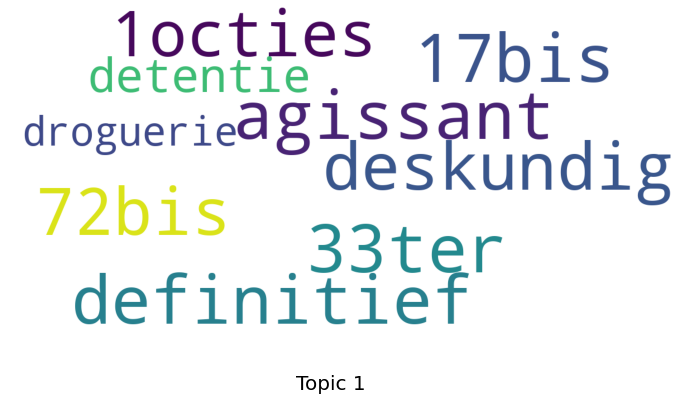

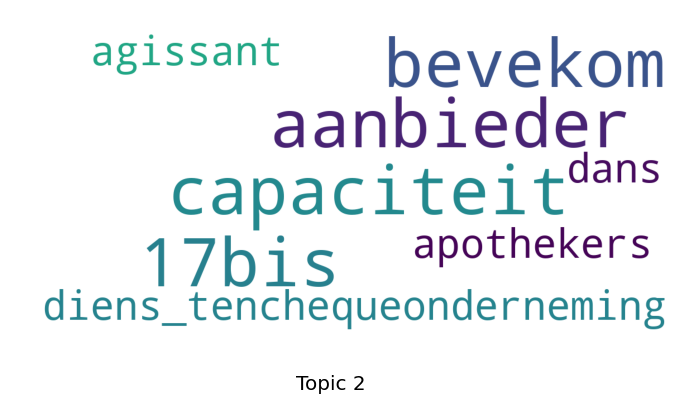

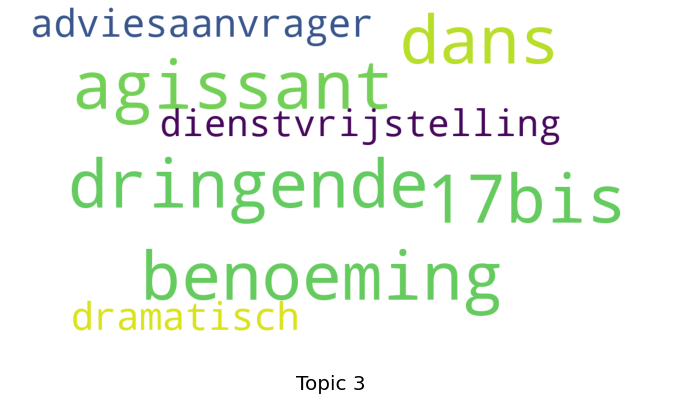

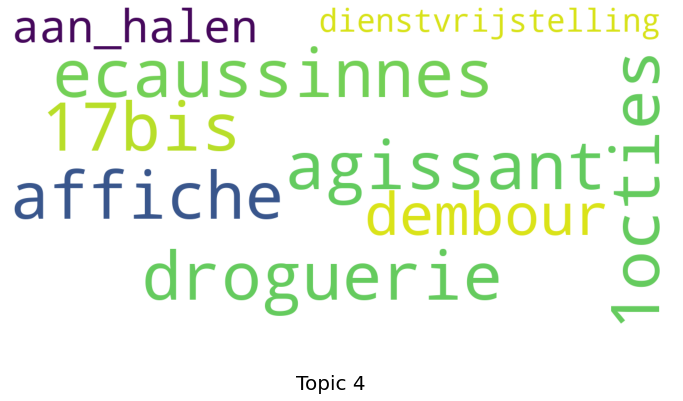

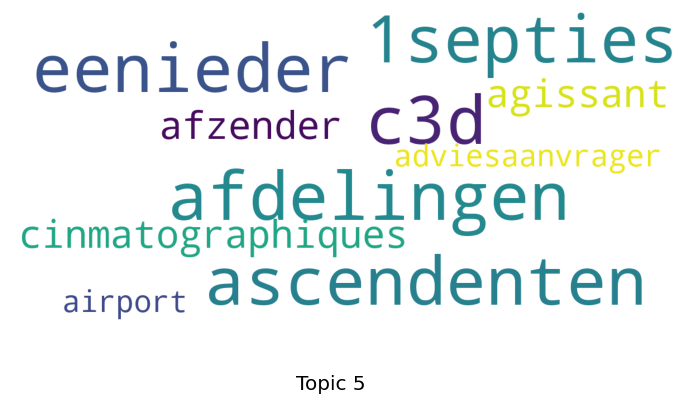

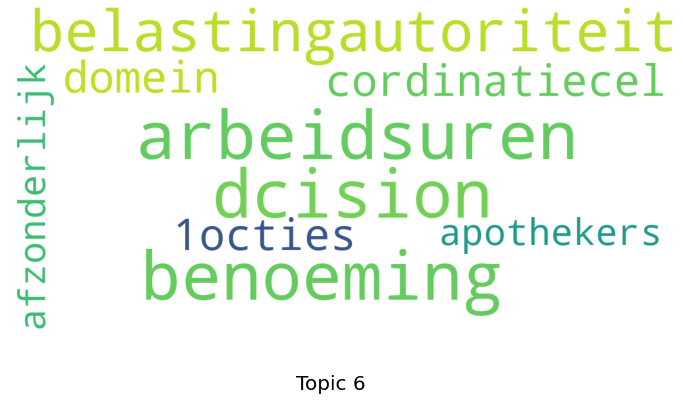

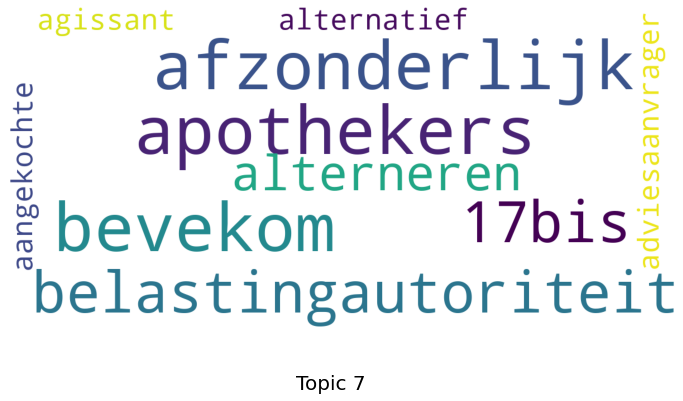

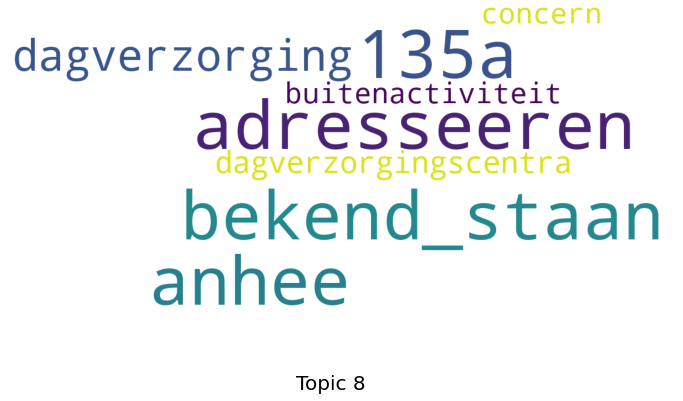

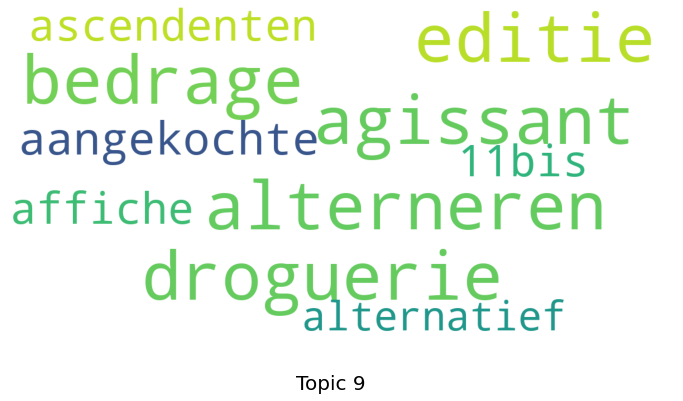

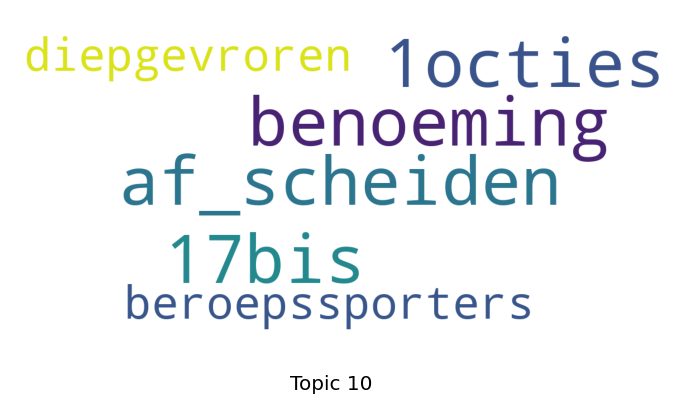

In [35]:
no_top_words = 13
display_topics(lda, tfidf_feature_names, no_top_words)